In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
import collections
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

In [9]:
data_cats = ['idea', 'design']
data_keys = {'idea': ['bike', 'cheat', 'meeting', 'night', 'visitor'], 
             'design': ['ai_character', 'olympic']}
data_keys_arr = data_keys['idea'] + data_keys['design']
d_arr = [2, 3]
num_labels_arr = [1000, 2000, 5000, 10000, 20000]
methods = ['crowdea_%d' % d for d in d_arr]
methods += ['blade_chest_%d_x' % d for d in d_arr] + ['blade_chest_%d_y' % d for d in d_arr]
methods += ['bpr_%d' % d for d in d_arr]
methods += ['crowdbt', 'bt']

In [10]:
ndcg5_dfs = []
ndcg10_dfs = []
for num_labels in num_labels_arr:
    for trial in range(10):
        # implemented in code/best_ndcg.py
        ndcg5_df = pd.read_csv('../ndcg/ndcg5_data_%d_%d.csv' % (num_labels, trial), index_col=0)
        ndcg10_df = pd.read_csv('../ndcg/ndcg10_data_%d_%d.csv' % (num_labels, trial), index_col=0)
        ndcg5_df['num_labels'] = num_labels
        ndcg5_df['trial'] = trial
        ndcg10_df['num_labels'] = num_labels
        ndcg10_df['trial'] = trial
        ndcg5_dfs.append(ndcg5_df)
        ndcg10_dfs.append(ndcg10_df)
        
ndcg5_df = pd.concat(ndcg5_dfs)
ndcg10_df = pd.concat(ndcg10_dfs)

score_dfs = {}
score_dfs['ndcg5'] = ndcg5_df
score_dfs['ndcg10'] = ndcg10_df

In [11]:
# select best parameters of BT and CrowdBT for each (measure, data_key)
best_params = collections.defaultdict(dict)

for measure in score_dfs.keys():
    score_df = score_dfs[measure]
    for method in methods:        
        if 'crowdea' in method:
            continue
        avg_df = score_df.loc[score_df.method == method].groupby(['data_key', 'method', 'num_labels', 'trial', 'param']).mean()
        for data_key in data_keys_arr:
            for num_labels in num_labels_arr:
                if data_key == 'olympic' and num_labels == 20000:
                    continue
                for trial in range(10):
                    tmp_df = avg_df.loc[(data_key, method, num_labels, trial)]
                    tmp_df = tmp_df.sample(tmp_df.shape[0]) # for tie-breaking
                    best_params[measure][(method, data_key, num_labels, trial)] = tmp_df.sort_values(measure, ascending=False).index[0]

In [12]:
ndcg5_data = []
ndcg10_data = []

ndcg5_df = score_dfs['ndcg5']
ndcg10_df = score_dfs['ndcg10']

for data_key in data_keys_arr:
    for method in methods:
        for num_labels in num_labels_arr:
            if data_key == 'olympic' and num_labels == 20000:
                    continue
                    
            for trial in range(10):
                if 'crowdea' in method:
                    ndcg5 = ndcg5_df.loc[(ndcg5_df.data_key == data_key) & 
                                         (ndcg5_df.num_labels == num_labels) & 
                                         (ndcg5_df.method == method) & 
                                         (ndcg5_df.trial == trial), 'ndcg5'].values.mean()
                    ndcg10 = ndcg10_df.loc[(ndcg10_df.data_key == data_key) & 
                                         (ndcg10_df.num_labels == num_labels) & 
                                         (ndcg10_df.method == method) & 
                                         (ndcg10_df.trial == trial), 'ndcg10'].values.mean()
                else:
                    param_ndcg5 = best_params['ndcg5'][(method, data_key, num_labels, trial)]
                    param_ndcg10 = best_params['ndcg10'][(method, data_key, num_labels, trial)]
                    
                    ndcg5 = ndcg5_df.loc[(ndcg5_df.data_key == data_key) & 
                                         (ndcg5_df.num_labels == num_labels) & 
                                         (ndcg5_df.method == method) & 
                                         (ndcg5_df.trial == trial) & 
                                         (ndcg5_df.param == param_ndcg5), 'ndcg5'].values.mean()
                    ndcg10 = ndcg10_df.loc[(ndcg10_df.data_key == data_key) & 
                                         (ndcg10_df.num_labels == num_labels) & 
                                         (ndcg10_df.method == method) & 
                                         (ndcg10_df.trial == trial) & 
                                         (ndcg10_df.param == param_ndcg10), 'ndcg10'].values.mean()
                    
                ndcg5_data.append({'data_key': data_key, 'ndcg5': ndcg5, 'method': method, 
                                       'num_labels': num_labels, 'trial': trial})
                ndcg10_data.append({'data_key': data_key, 'ndcg10': ndcg10, 'method': method, 
                                       'num_labels': num_labels, 'trial': trial})
                
score_dfs['ndcg5'] = pd.DataFrame(ndcg5_data)
score_dfs['ndcg10'] = pd.DataFrame(ndcg10_data)

In [13]:
avg_dfs = {}
for measure in score_dfs.keys():
    avg_dfs[measure] = score_dfs[measure].groupby(['data_key', 'method', 'num_labels']).mean()

In [15]:
result_dfs = {}

for measure in score_dfs.keys():
    tmp_methods = ['crowdea_%d' % d for d in d_arr]
    tmp_methods += ['blade_chest_%d' % d for d in d_arr]
    tmp_methods += ['bpr_%d' % d for d in d_arr]
    tmp_methods += ['crowdbt', 'bt']        
        
    for method in tmp_methods:    
        result_df = pd.DataFrame(index=data_keys_arr, 
                                 columns=['#labels=%d' % n for n in num_labels_arr])
        
        for data_key in data_keys_arr:
            for num_labels in num_labels_arr:
                if data_key == 'olympic' and num_labels == 20000:
                    v = np.nan
                else:
                    if 'blade_chest' in method:
                        v_x = avg_dfs[measure].loc[(data_key, method+'_x', num_labels), measure]
                        v_y = avg_dfs[measure].loc[(data_key, method+'_y', num_labels), measure]
                        v = np.max([v_x, v_y])
                    else:
                        v = avg_dfs[measure].loc[(data_key, method, num_labels), measure]
                    
                result_df.loc[data_key, '#labels=%d' % num_labels] = v
        result_dfs[(measure, method)] = result_df

In [16]:
data_key_tex = {}
for data_key in data_keys_arr:
    data_key_tex[data_key] = data_key.capitalize()
    if data_key == 'ai_character':
        data_key_tex[data_key] = 'Character'
        
color_dict = {
    'bt': '#e4ad44', 
    'crowdbt': '#f95039',
    'crowdea': '#1790d2',
    'bpr': '#80187a',
    'blade-chest': '#d81B60',
    }

marker_dict = {
    'bt': 'x',
    'crowdbt': '.', 
    'crowdea': 'o',
    'bpr': 's',
    'blade-chest': 'p'
}

label_dict = {
    'bt': 'BT',
    'crowdbt': 'CrowdBT',
    'crowdea': 'CrowDEA',
    'bpr': 'BPR', 
    'blade-chest': 'Blade-chest'
}

methods = ['crowdea_%d' % d for d in d_arr]
methods += ['blade_chest_%d' % d for d in d_arr]
methods += ['bpr_%d' % d for d in d_arr]
methods += ['crowdbt', 'bt'] 
    
for method in methods:
    if 'crowdea' in method:
        color_dict[method] = color_dict['crowdea']
        marker_dict[method] = marker_dict['crowdea']
        label_dict[method] = label_dict['crowdea']
    elif 'blade_chest' in method:
        color_dict[method] = color_dict['blade-chest']
        marker_dict[method] = marker_dict['blade-chest']
        label_dict[method] = label_dict['blade-chest']
    elif 'bpr' in method:
        color_dict[method] = color_dict['bpr']
        marker_dict[method] = marker_dict['bpr']
        label_dict[method] = label_dict['bpr']
        
methods_d = {}
methods_d[2] = ['bt', 'crowdbt', 'blade_chest_2', 'bpr_2', 'crowdea_2']
methods_d[3] = ['bt', 'crowdbt', 'blade_chest_3', 'bpr_3', 'crowdea_3']

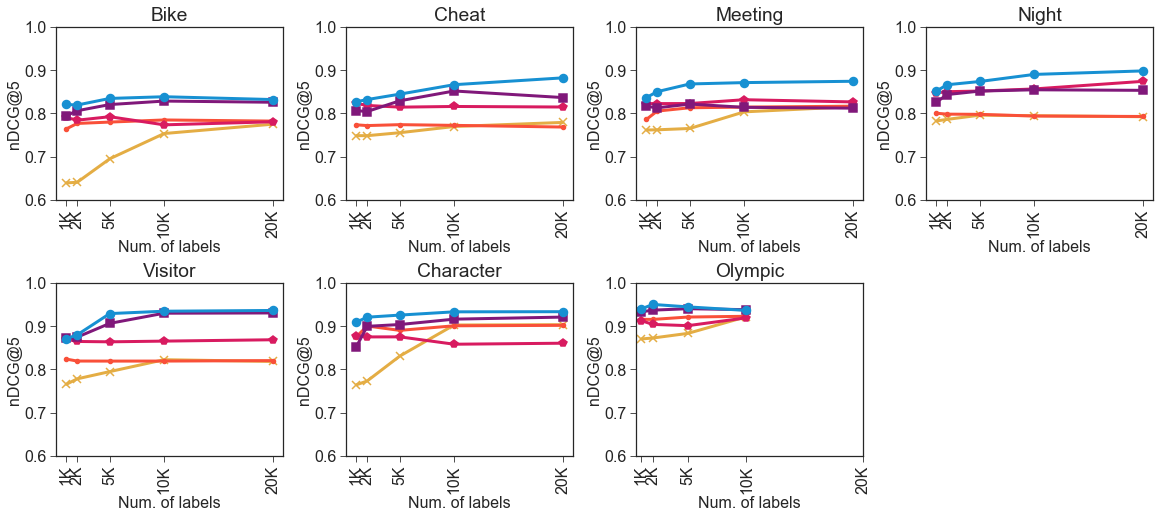

In [17]:
measure = 'ndcg5'
d = 2

plt.figure(figsize=(16, 7))
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 16

x = num_labels_arr

for i, data_key in enumerate(data_keys_arr):
    ax = plt.subplot(2, 4, i+1)
    
    for method in methods_d[d]:
        y = [result_dfs[(measure, method)].loc[data_key, '#labels=%d' % num_labels] for num_labels in num_labels_arr]
        label = label_dict[method]
        plt.plot(x, y, '%s-' % marker_dict[method], color=color_dict[method], label=label, lw=3, ms=8, mew=1.5, mec=color_dict[method])

    plt.title(data_key_tex[data_key])    
    plt.ylim(0.6, 1.0)
    plt.xlabel('Num. of labels', labelpad=2)
    if measure == 'ndcg5':
        plt.ylabel('nDCG@5', labelpad=2)
    else:
        plt.ylabel('nDCG@10', labelpad=2)
        
    plt.xticks([1000, 2000, 5000, 10000, 20000], rotation = 90) 
    ax.set_xticklabels(['1K', '2K', '5K', '10K', '20K'])
    
anchor_y = -0.7
#plt.legend(loc="lower center", bbox_to_anchor=(-0.8, anchor_y), ncol=4)
plt.tight_layout(pad=0., w_pad=0.5, h_pad=0.5)
#plt.savefig('fig_efficiency_label_d%d_%s.pdf' % (d, measure), bbox_inches="tight", pad_inches=0.)